# PHXS 491_001: Observational Astronomy - Exam 2

### Due Monday, Nov 9, 2021
Remember to save your completed notebook as a PDF and upload both ipynb/PDF to Brightspace/D2L under Assignments.

Name:

## Please use the "primt()" function (notice the "m") to print out your answers in magenta.  This makes grading easier.  You might need to "print to PDF" to get the colors to show up.

In [1]:
def primt(*args):
    '''
    For any amount of arguments "*args", prints in magenta.
    '''
    magenta = "\x1B[38;5;201m"   # the color in ANSI code
    for el in args:  # for each argument
        magenta += " "+(str(el))  # add the argument to the string to be printed
    print(magenta)   #print!

In [59]:
import os
import numpy as np
from bozepy import ccdproc
from glob import glob
from astropy.io import fits
import matplotlib.pyplot as plt
import scipy.ndimage as ndimage
from astropy.stats import sigma_clipped_stats
from astropy.stats import SigmaClip, sigma_clipped_stats, mad_std
from photutils import aperture_photometry, CircularAperture, CircularAnnulus
from astropy.io import fits
from astropy.table import Table
import scipy.stats as stats
from photutils import Background2D, MedianBackground

# %matplotlib notebook
%matplotlib inline

In [5]:
path = "data/"

Make sure you have the ``exam2_data.zip`` file.

## 1) CCD image calibration:

Use ``masterbias()`` from ``bozepy.ccdproc`` and the 10 provided bias images to create a master bias frame.

In [6]:
out=ccdproc.ccdlist(f'{path}*.fit', outprint=False)
biases = np.where("Bias Frame" == out['imagetyp'])
bias_list = out[biases]['file']
if f'{path}master_bias.fit'.replace("/", "\\") in bias_list: bias_list = bias_list[:-1]
# print(bias_list)
im, head = ccdproc.masterbias(files=bias_list, outfile=f"{path}master_bias.fit", clobber=True)

PermissionError: [WinError 32] The process cannot access the file because it is being used by another process: 'data/master_bias.fit'

## 2) CCD image reduction:

Use your master bias image and the provided master dark and flat images to reduce the three science ``DoubleCluster`` exposures with the ``ccdproc()`` function in the ``bozepy.ccdproc`` module.

In [8]:
out=ccdproc.ccdlist(f'{path}*.fit', outprint=False)
sci = np.where("Light Frame" == out['imagetyp'])
sci_list = out[sci]['file']
im, head = ccdproc.ccdproc(sci_list, zero=f"{path}master_bias.fit", dark=f"{path}master_dark.fit", flat=f"{path}master_flat.fit",
                            outfile=True, verbose=True, outsuffix="_proc", clobber=True)

Loading data\DoubleCluster-0003B.fit
Tue Nov  9 15:02:15 2021 Overscan is [1:41,1:2728] and [3430:3465,1:2728], mean 958.2760882812214
Tue Nov  9 15:02:15 2021 Trimming to [42:3429,15:2726]
Tue Nov  9 15:02:15 2021 ZERO: mean   0.20, stdev   8.56
Tue Nov  9 15:02:15 2021 DARK: mean   2.00, stdev  14.73
Tue Nov  9 15:02:16 2021 FLAT: mean   1.00, stdev   0.05
Tue Nov  9 15:02:16 2021 CCD processing done
Writing processed file to data/DoubleCluster-0003B_proc.fits
Loading data\DoubleCluster-0003B.fit
Tue Nov  9 15:02:16 2021 Overscan is [1:41,1:2728] and [3430:3465,1:2728], mean 958.7815058841459
Tue Nov  9 15:02:16 2021 Trimming to [42:3429,15:2726]
Tue Nov  9 15:02:16 2021 ZERO: mean   0.20, stdev   8.56
Tue Nov  9 15:02:17 2021 DARK: mean   2.00, stdev  14.73
Tue Nov  9 15:02:17 2021 FLAT: mean   1.00, stdev   0.05
Tue Nov  9 15:02:17 2021 CCD processing done
Writing processed file to data/DoubleCluster-0003R_proc.fits
Loading data\DoubleCluster-0003B.fit
Tue Nov  9 15:02:18 2021 Over

## 3) Calculating centroids and sigma with moments:

a) Calculate the X/Y centroids of the star near X=785 and Y=780 in image ``DoubleCluster-0003B.fit`` using the first moment.  Remember that you need to subtract a median background value from your image "thumbnail".

b) Display the 2D image thumbnail and overplot your centroid position to check that it is reasonable.

c) Calculate the sigma/spread of the star using the second moment.  

d) Make cross-section plots (along the central column and then along the central row) and overplot your centroid positions (as a vertical line) and make a horiztonal line for your sigma values (converted to FWHM = 2.35*sigma).

<IPython.core.display.Javascript object>


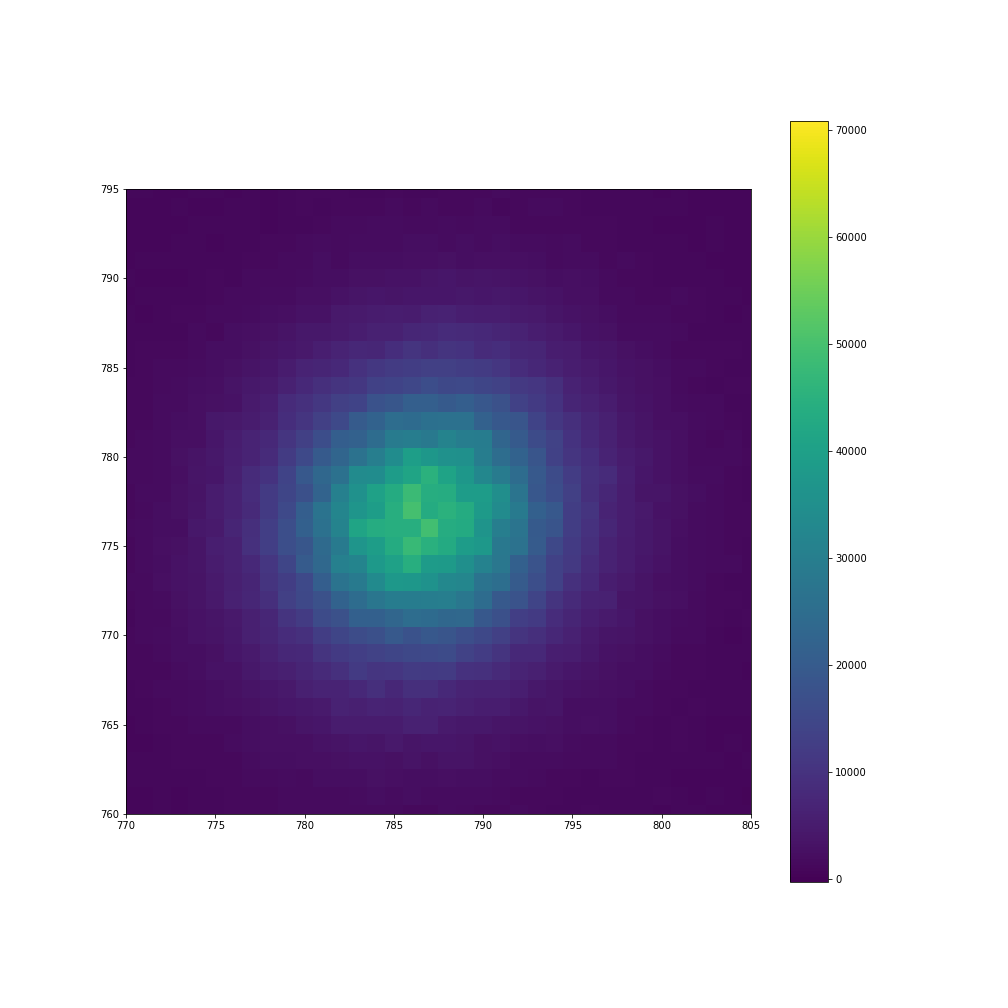

In [47]:
im, head = fits.getdata(f'{path}DoubleCluster-0003B_proc.fits',0,header=True)

plt.figure(figsize=(14,14))
plt.imshow(im)
plt.xlim(770, 805)
plt.ylim(760, 795)
plt.colorbar()
plt.show()

In [66]:
sigma_clip = SigmaClip(sigma=3.)
bkg_estimator = MedianBackground()
bkg = Background2D(im, (200, 200), filter_size=(3, 3),
                   sigma_clip=sigma_clip, bkg_estimator=bkg_estimator)
# Subtract the background
sim = im - bkg.background

im2 = sim[760:795, 770:805].copy()
im2[im2<0] = 0
ny,nx = im2.shape
xx,yy = np.meshgrid(np.arange(nx)+770,np.arange(ny)+ 760)
mnx = np.sum(im2*xx) / np.sum(im2)
print(mnx)
mny = np.sum(im2*yy) / np.sum(im2)
print(mny)

786.6988655584667
776.6714183628218


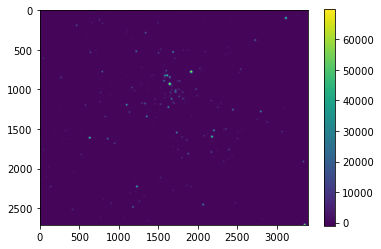

In [67]:
plt.imshow(sim)
plt.colorbar()
plt.show()

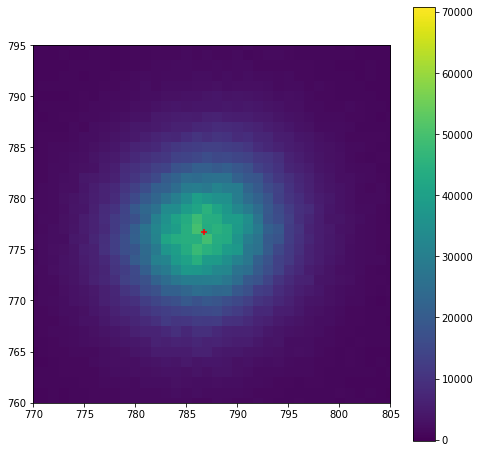

In [68]:
fig = plt.figure(figsize=(8,8))
plt.imshow(im,origin='lower')
plt.colorbar()
plt.xlim(770, 805)
plt.ylim(760, 795)
plt.scatter([mnx],[mny],c='r',marker='+')


In [86]:
(770-805)/2
(760-795)/2

-17.5

5.69022047225463
5.72212307168141


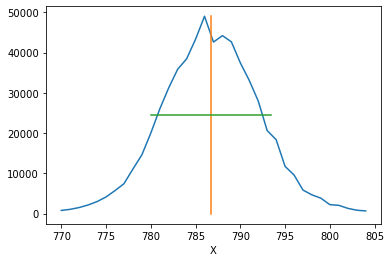

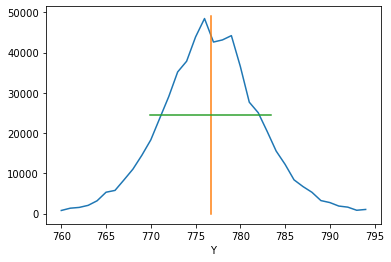

In [85]:
sigx2 = np.sum(im2*(xx-mnx)**2) / np.sum(im2)
sigx = np.sqrt(sigx2)
print(sigx)

sigy2 = np.sum(im2*(yy-mny)**2) / np.sum(im2)
sigy = np.sqrt(sigy2)
print(sigy)

maxflx = np.max(im2)

x = np.arange(nx)+770
plt.plot(x,im2[17,:])
plt.plot([mnx,mnx],[-100,maxflx])
plt.plot([-sigx*2.35/2+mnx,sigx*2.35/2+mnx],[0.5*maxflx,0.5*maxflx])
plt.xlabel('X')
plt.show()

y = np.arange(ny)+760
plt.plot(y,im2[:,17])
plt.plot([mny,mny],[-100,maxflx])
plt.plot([-sigy*2.35/2+mny,sigy*2.35/2+mny],[0.5*maxflx,0.5*maxflx])
plt.xlabel('Y')
plt.show()

## 4) Background estimation and subtraction

a) Use the photutils ``Background2D`` to estimate the background for images ``DoubleCluster-0003B.fit`` and ``DoubleCluster-0003R.fit`` using a 250x250 box size for estimating the statistics.  Plot the background model for one of them.

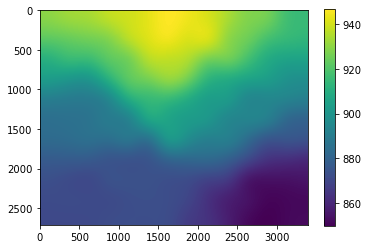

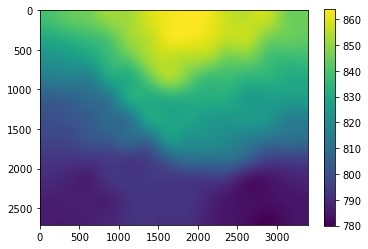

In [90]:
imB, headB = fits.getdata(f'{path}DoubleCluster-0003B_proc.fits',0,header=True)
sigma_clip = SigmaClip(sigma=3.)
bkg_estimator = MedianBackground()
bkgB = Background2D(imB, (250, 250), filter_size=(3, 3),
                   sigma_clip=sigma_clip, bkg_estimator=bkg_estimator)

imR, head = fits.getdata(f'{path}DoubleCluster-0003R_proc.fits',0,header=True)
bkgR = Background2D(imR, (250, 250), filter_size=(3, 3),
                   sigma_clip=sigma_clip, bkg_estimator=bkg_estimator)

plt.imshow(bkgB.background)
plt.colorbar()
plt.show()

plt.imshow(bkgR.background)
plt.colorbar()
plt.show()

b) Subtract the background from the images and put it in a new variable, e.g. ``subim``.

In [96]:
# Subtract the background
subimB = imB - bkgB.background
subimR = imR - bkgR.background

## 5) Detection

a) Use the photutils ``DAOStarFinder`` detection routine to perform detection on the two background-subtracted images.  For the FWHM, use the sigma value (converted to FWHM) you calculated above for the star in ``DoubleCluster-0003B.fit``.  Set the threshold at 5 standard deviations above the background value (which you need to calculate first).

In [99]:
from photutils import DAOStarFinder
mean, median, std = sigma_clipped_stats(subimB, sigma=3.0)
daofind = DAOStarFinder(fwhm=17.5, threshold=5.*std)  
sources = daofind(subimB) 


b) Plot the image and your detected sources on top

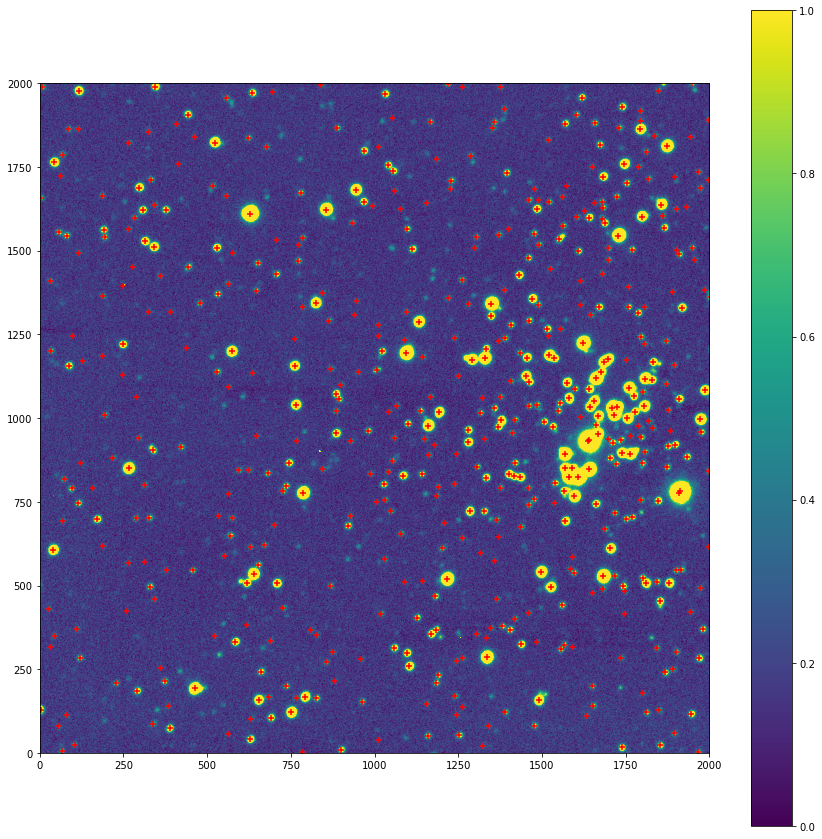

In [100]:
fig = plt.figure(figsize=(15,15))
plt.imshow(subimB,vmin=-100,vmax=500)
plt.xlim(0,2000)
plt.ylim(0,2000)
plt.scatter(sources['xcentroid'],sources['ycentroid'],c='r',marker='+')
plt.colorbar()
plt.show()

## 6) Aperture photometry

Perform aperture photometry for the two catalogs of detected sources using ``bozepy.phot.aperphot()``.  Use an aperture of radius 6 pixels, inner background radius of 10 pixels and outer background radius of 20 pixels.

b) Convert the fluxes to magnitudes with a constant offset of 25.0.

c) Add these to a new ``mag`` column in the ``phot`` catalogs.

## 7) WCS correction:

Image ``DoubleCluster-0003B.fit`` has an initial WCS in the header, but it has a small offset.  The star at X=465 and Y=194 is known to have the coordinates RA=34.927769, DEC=56.979407.  Use this information to fix the WCS (*HINT: You want to modify the CRVAL and CRPIX values.  Astropy WCS also seems to prefer setting both values of CRVAL or CRPIX at time by giving it a two-element list, rather than one at a time*).

## 8) Gaia catalog. Plot CMD.

Load the provided ``DoubleCluster_gaiadr2.fits`` Gaia DR2 catalog.  Plot the G vs. Bp-Rp color-magnitude diagram (the columns are ``PHOT_XX_MEAN_MAG``).  Make sure that brighter objects are at the top.

## 9) Calibrating magnitudes with Gaia.

a) Use the WCS that you corrected above to calculate X/Y positions for the Gaia stars.

b) Plot the image and your detected sources on top.

c) Plot the Gaia sources on top as well (using a different symbol/color).  

d) Pick out **one** star that is in your detected sources and in Gaia.  It might help to zoom into a smaller region that has at least roughly 10 stars.  Figure out the rough X/Y values and use ``np.where()`` to select the relevant row from each catalog.

e) Now compare the Gaia BP magnitude to your ``DoubleCluster-0003B.fit`` magnitudes.  Figure out the offset between the two.  This is the zeropoint offset. Apply this offset to all of the stars in your catalog for this image (be sure to use the correct sign).

f) Do the same for ``DoubleCluster-0003R.fit`` and compare to the Gaia RP magnitudes.

## 10) Crossmatching

Crossmatch the sources in your two photometry catalogs using the ``xcenter`` and ``ycenter`` values and the ``dlnpyutils.coords.xmatch()`` function.

a) Use ``xmatch()`` to crossmatch the two catalogs.

b) Use the two index lists to create two new "matched" catalogs.

## 11) Color Magnitude Diagram.

Make a color magnitude diagram using your matched catalogs and calibrated photometry.  MAG_3R vs. MAG_3B - MAG_3R.  Make sure the brighter stars are at the top.